In [63]:
from transformers import GPT2Config, GPT2LMHeadModel
import pickle
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
with open("data/preprocessed/100k/vocab.pkl", "rb") as f:
    vocab, itos, stoi = pickle.load(f)

space_idx = stoi[" "]

In [3]:
# Comes from data preprocessing
bptt = 256
def load_data(path):
    x = torch.load(path+'_x.pt')
    y = torch.load(path+'_y.pt')
    lens = torch.load(path+'_lens.pt')

    idx = torch.cat([torch.tensor([0]), torch.cumsum(lens, 0)])

    y = [y[idx[i]:idx[i+1]].to(device) for i in range(len(idx)-1)]

    return x.to(device), y

X_train, Y_train = load_data("data/preprocessed/100k/train")
X_valid, Y_valid = load_data("data/preprocessed/100k/valid")
X_test, Y_test = load_data("data/preprocessed/100k/test")

bs = 32

# Precompute Y_batches given bs
Y_batches = []
for i in range(0, len(Y_train), bs):
    Y_batches.append(torch.cat(Y_train[i:i+bs], axis=0))

Y_val_batches = []
for i in range(0, len(Y_valid), bs):
    Y_val_batches.append(torch.cat(Y_valid[i:i+bs], axis=0))

In [58]:
def train(model, optimizer, verbose=True, log=[]):

    criterion = nn.CrossEntropyLoss()

    total_loss = 0.
    total_p_acc = 0.
    total_b_acc = 0.
    start_time = time.time()

    for i in range(0, len(X_train), bs):
        batch = i//bs+1

        X_batch = X_train[i:i+bs]
        spaces = torch.where(X_batch == stoi[" "])
        
        Y_batch = Y_batches[i//bs]
        
        # Fucking kill me.  Torch expects bptt dim first instead of batch
        output = model(X_batch).logits.view(-1, bptt, 8, 8, 13)

        y_pred = output[spaces[0], spaces[1]]

        loss = criterion(y_pred.view(-1, 13), Y_batch.view(-1))

        equal = (y_pred.argmax(-1) == Y_batch)

        piece_acc = equal.float().mean().item()
        board_acc = equal.all(-1).all(-1).float().mean().item()


        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        total_p_acc += piece_acc
        total_b_acc += board_acc

        ms_per_batch = (time.time() - start_time) * 1000 / batch
        cur_loss = total_loss / batch
        cur_p_acc = total_p_acc / batch
        cur_b_acc = total_b_acc / batch

        if verbose:
            print(f'| {batch:5d}/{len(X_train)//bs+1:5d} batches | '
                    f'ms/batch {ms_per_batch:5.2f} | '
                    f'loss {cur_loss:5.2f} | piece acc {cur_p_acc:5.2f} | board acc {cur_b_acc:5.2f} ', end="\r")
        
        log.append({"loss":loss.item(), "piece_acc":piece_acc, "board_acc":board_acc})

    if verbose:
        print()

    return log

In [66]:
@torch.no_grad()
def evaluate(model):
    criterion = nn.CrossEntropyLoss()

    val_losses = []
    p_accs = []
    b_accs = []

    for i in range(0, len(X_valid), bs):
        Y_batch = Y_val_batches[i//bs]
        X_batch = X_valid[i:i+bs]
        spaces = torch.where(X_batch == stoi[" "])
        
        output = model(X_batch).logits.view(-1, bptt, 8, 8, 13)

        y_pred = output[spaces[0], spaces[1]]

        loss = criterion(y_pred.view(-1, 13), Y_batch.view(-1)).item()

        equal = (y_pred.argmax(-1) == Y_batch)

        piece_acc = equal.float().mean().item()
        board_acc = equal.all(-1).all(-1).float().mean().item()

        p_accs.append(piece_acc)
        b_accs.append(board_acc)
        val_losses.append(loss)

    return {"val_loss":np.mean(val_losses), "val_piece_acc":np.mean(p_accs), "val_board_acc":np.mean(b_accs)}

In [30]:
def create_model(config, verbose=True):
    model = GPT2LMHeadModel(config)
    model.lm_head = nn.Linear(config.n_embd, 8*8*13)
    if verbose:
        print(f"Parameter count: {sum(p.numel() for p in model.parameters())/1e6:.1f}M")
    return model.to(device)

In [67]:
val_results = []

for n_layer in range(1, 7):

    config = GPT2Config(
        vocab_size=len(vocab),
        n_layer=n_layer,
        n_head=4,
        n_embd=256,
        resid_pdrop=0,
        embd_pdrop=0,
        attn_pdrop=0,
    )

    model = create_model(config)

    epochs = 10

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    log = []

    for epoch in tqdm(range(1, 1+epochs)):
        log = train(model, optimizer, verbose=False, log=log)

    model.save_pretrained(f"models/{n_layer}_layer")
    with open(f"models/{n_layer}_layer/log.pkl", "wb") as f:
        pickle.dump(log, f)

    val_results.append(evaluate(model))

with open(f"val_results.pkl", "wb") as f:
    pickle.dump(val_results, f)

Parameter count: 1.3M


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [07:55<00:00, 47.51s/it]


Parameter count: 2.1M


100%|██████████| 10/10 [13:08<00:00, 78.90s/it]


Parameter count: 2.9M


100%|██████████| 10/10 [16:55<00:00, 101.54s/it]


Parameter count: 3.6M


100%|██████████| 10/10 [21:20<00:00, 128.02s/it]


Parameter count: 4.4M


100%|██████████| 10/10 [26:00<00:00, 156.03s/it]


Parameter count: 5.2M


100%|██████████| 10/10 [30:54<00:00, 185.46s/it]


In [68]:
print(val_results)

[{'val_loss': 0.3628068519795494, 'val_piece_acc': 0.8668139337990355, 'val_board_acc': 0.2098455526532}, {'val_loss': 0.04553631770145541, 'val_piece_acc': 0.9844584568140375, 'val_board_acc': 0.6061260467591668}, {'val_loss': 0.020050761248633454, 'val_piece_acc': 0.9935277508029455, 'val_board_acc': 0.7683776888666274}, {'val_loss': 0.034004968068393475, 'val_piece_acc': 0.988490576231027, 'val_board_acc': 0.6813413362462812}, {'val_loss': 0.01372150114132288, 'val_piece_acc': 0.9956815192468056, 'val_board_acc': 0.8242776043052915}, {'val_loss': 0.016787678296068677, 'val_piece_acc': 0.9946751921488766, 'val_board_acc': 0.7994992403541437}]


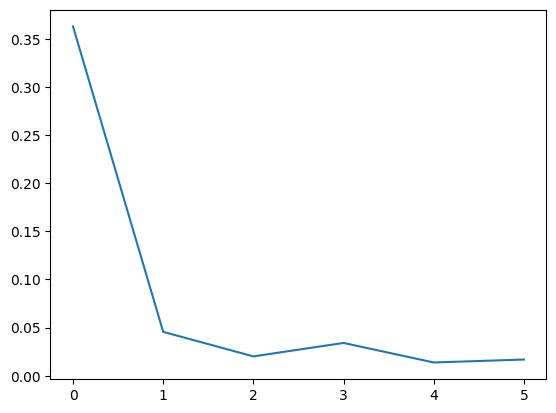

In [70]:
plt.plot([e['val_loss'] for e in val_results])

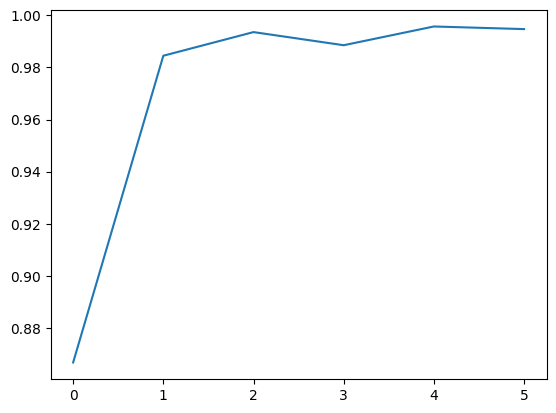

In [71]:
plt.plot([e['val_piece_acc'] for e in val_results])

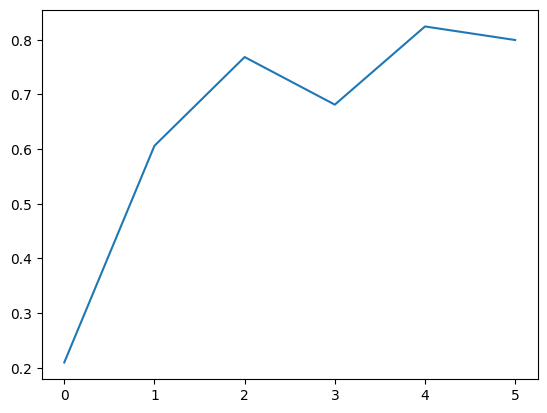

In [72]:
plt.plot([e['val_board_acc'] for e in val_results])